# Train CL - Train Data Only

## Dependencies & Set up

### Dependencies

In [34]:
import os
import ast
import json
import math
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from py_irt import scoring
from torchinfo import summary
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sortedcontainers import SortedDict
import pickle
from matplotlib import pyplot as plt

### Path

In [19]:
cwd = os.getcwd()
data_path = os.path.join(cwd, 'aug_data')
task_path = os.path.join(cwd, 'train_only_data', 'task')
valid_task_path = os.path.join(cwd, 'train_only_data', 'valid_task')
difficulties_path = os.path.join(cwd, 'train_only_data', 'fitted_IRT')


print(cwd)
print(data_path)
print(task_path)
print(valid_task_path)
print(difficulties_path)

c:\Users\hhl08\Desktop\CL-crowd-training
c:\Users\hhl08\Desktop\CL-crowd-training\aug_data
c:\Users\hhl08\Desktop\CL-crowd-training\train_only_data\task
c:\Users\hhl08\Desktop\CL-crowd-training\train_only_data\valid_task
c:\Users\hhl08\Desktop\CL-crowd-training\train_only_data\fitted_IRT


### Seed

In [4]:
seed = 4747

# numpy
np.random.seed(seed)
# random
random.seed(seed)
# pytorch
torch.manual_seed(seed)

### Device

In [5]:
# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3090


## Merge Data

### Check before merge

In [6]:
train_class = "Perspective"

file_va = json.load(open(os.path.join(difficulties_path, train_class, 'best_parameters.json')))
file_va.keys()

dict_keys(['ability', 'diff', 'irt_model', 'item_ids', 'subject_ids'])

In [7]:
file_va['diff'][0:5]

[-1.2691941261291504,
 -2.416630744934082,
 -2.4665095806121826,
 -2.4016575813293457,
 -1.2968376874923706]

In [8]:
list(file_va['item_ids'].items())[0:5]

[('0', '7db0d3a1-b8e4-4ff6-96e3-cc55d9cb77a3'),
 ('1', '2b8e660a-ebfc-4c18-a3d3-295fed1dc8f4'),
 ('2', '6317c474-d3fd-418d-9fa0-217506a75f56'),
 ('3', '510ff0b4-8773-41d1-9182-e1078f6336b4'),
 ('4', 'd5eafd31-3a7c-4746-9329-1639ee8aee14')]

In [8]:
ids = [file_va['item_ids'][i] for i in file_va['item_ids']]
diff_data = pd.DataFrame({'ID': ids, 'diff': file_va['diff']})
diff_data.head()

,ID,diff
0,86b8c8eb-0df9-4ebc-b9cc-5c284e449cc7,-1.269194
1,bf1b327c-f966-4d39-b154-ebc1015f9ed7,-2.416631
2,703c5529-bd01-436a-8574-9582785cb1e1,-2.466510
3,5ec5d70c-8668-407c-bf36-8d78bed88995,-2.401658
4,1fcde17b-18c4-49ac-90ed-1310228cae9d,-1.296838


### Merge all classes

### Merge Train Data

In [28]:
labels = ['Country','Intervention','Perspective','Population','Sample Size','Study Period']
IRT_train = {}

for train_class in labels:
    print(f'Merging {train_class}')
    # load task & diff
    file_va = json.load(open(os.path.join(difficulties_path, train_class, 'best_parameters.json')))
    ids = [file_va['item_ids'][i] for i in file_va['item_ids']]
    diff_data = pd.DataFrame({'ID': ids, 'diff': file_va['diff']})
    task_data = pd.read_csv(os.path.join(task_path, f'{train_class}.csv'))
    merged_df = pd.merge(task_data, diff_data, on='ID')
    merged_df['Pos_support_locs'] = merged_df['Pos_support_locs'].apply(lambda x: ast.literal_eval(x))
    merged_df['Neg_support_locs'] = merged_df['Neg_support_locs'].apply(lambda x: ast.literal_eval(x))
    IRT_train[train_class] = merged_df[["ID","Pos_support_locs","Neg_support_locs", "Query_loc","Label","Alpha","Aug_type","diff"]]
    print(f'Train size: {len(merged_df)}')

Merging Country
Train size: 34996
Merging Intervention
Train size: 34997
Merging Perspective
Train size: 34995
Merging Population
Train size: 34998
Merging Sample Size
Train size: 34993
Merging Study Period
Train size: 34997


### Load Evaluation Data

In [29]:
labels = ['Country','Intervention','Perspective','Population','Sample Size','Study Period']
IRT_eval = {}

for train_class in labels:
    print(f'Merging {train_class}')
    # load task
    task_data = pd.read_csv(os.path.join(valid_task_path, f'{train_class}.csv'))
    task_data['Pos_support_locs'] = task_data['Pos_support_locs'].apply(lambda x: ast.literal_eval(x))
    task_data['Neg_support_locs'] = task_data['Neg_support_locs'].apply(lambda x: ast.literal_eval(x))
    IRT_eval[train_class] = task_data[["ID","Pos_support_locs","Neg_support_locs", "Query_loc","Label","Alpha","Aug_type"]]
    print(f'Train size: {len(task_data)}')

Merging Country
Train size: 14983
Merging Intervention
Train size: 14985
Merging Perspective
Train size: 14981
Merging Population
Train size: 14982
Merging Sample Size
Train size: 14980
Merging Study Period
Train size: 14988


### Check

In [30]:
IRT_train['Perspective'].head()

,ID,Pos_support_locs,Neg_support_locs,Query_loc,Label,Alpha,Aug_type,diff
0,00005edd-1296-4630-9789-b5a5a23972f1,"[6, 225, 181, 0, 211]","[596, 207, 117, 322, 249]",417,0.0,1,3,-2.371309
1,0001c7fa-751f-478a-9e04-bfc836a0a514,"[4, 66, 181, 179, 11]","[111, 177, 634, 508, 630]",292,0.0,3,1,-2.408183
2,00036e5c-f52d-4c1c-a88e-bae07525c43a,"[34, 31, 35, 211, 58]","[443, 488, 583, 241, 268]",0,1.0,5,4,1.038628
3,00061dae-95a0-4afe-aee0-fb4baf6be08f,"[225, 7, 164, 39, 33]","[83, 347, 186, 424, 314]",385,0.0,0,4,0.268913
4,0008324d-24a1-4489-922d-2ddff8a7519f,"[5, 3, 67, 11, 51]","[449, 318, 506, 596, 503]",651,0.0,4,1,-2.429216


In [31]:
IRT_eval['Perspective'].head()

,ID,Pos_support_locs,Neg_support_locs,Query_loc,Label,Alpha,Aug_type
0,0002b905-1318-4a7a-b182-6bb79663e886,"[162, 8, 204, 179, 22]","[306, 145, 342, 331, 490]",117,0.0,0,0
1,0003fe41-aa46-4334-985c-d3e60ee43e73,"[4, 36, 57, 5, 13]","[435, 121, 472, 190, 620]",73,1.0,0,0
2,0006f5e9-e00a-41f6-81f4-484cb153a0f5,"[25, 15, 28, 35, 162]","[437, 126, 583, 628, 634]",53,1.0,0,0
3,000bb31e-883e-4a48-9c70-752ad9f23d99,"[11, 58, 187, 57, 28]","[564, 220, 333, 169, 277]",212,1.0,0,0
4,000bb35c-7762-4af1-bdb7-e7373ffecda1,"[47, 68, 216, 4, 15]","[171, 421, 155, 447, 593]",272,0.0,0,0


##  Load Word Vector

In [32]:
aug_token_embeddings = np.load(os.path.join(data_path, 'wordvector_masked_aug.npy'))
aug_token_embeddings.shape

(5, 4, 660, 100, 768)

In [33]:
token_embeddings = np.load(os.path.join(data_path, 'train_wordvectors.npy'))
token_embeddings.shape

(660, 100, 768)

## Data Loader

In [56]:
class InfiniteDataLoader:
    def __init__(self, dataset, batch_size=32, shuffle=True):
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.dataset = dataset
        self.data_loader = DataLoader(dataset=self.dataset, batch_size=self.batch_size, shuffle=self.shuffle).__iter__()

    def next_batch(self):
        try:
            return next(self.data_loader)
        except StopIteration:
            self.data_loader = DataLoader(self.dataset, self.batch_size, shuffle=self.shuffle).__iter__()
            return self.next_batch()


class CL_diff_generator(Dataset):
    def __init__(self, wv, aug_wv, id_subset, extract_dict, valid):
        self.wv = wv
        self.aug_wv = aug_wv
        self.extract_dict = extract_dict
        self.id_subset = id_subset
        self.valid = valid

    def __getitem__(self, index):
        cur_id = self.id_subset[index]
        cur_support_data, cur_query_data_x, cur_query_data_y = self.get_one_element_of_batch(cur_query_dict=self.extract_dict[cur_id])
        if not self.valid:
            cur_diff = self.extract_dict[cur_id]['diff']
            return cur_support_data, cur_query_data_x, cur_query_data_y, cur_diff
        else:
            return cur_support_data, cur_query_data_x, cur_query_data_y

    def __len__(self):
        return len(self.id_subset)

    def get_one_element_of_batch(self, cur_query_dict):
        # extract variables
        cur_alpha = cur_query_dict['Alpha']
        cur_aug_type = cur_query_dict['Aug_type']
        try:
            cur_pos_support_locs = ast.literal_eval(cur_query_dict['Pos_support_locs'])
        except ValueError as e:
            if isinstance(cur_query_dict['Pos_support_locs'], list):
                cur_pos_support_locs = cur_query_dict['Pos_support_locs']
            else:
                raise e
        try:
            cur_neg_support_locs = ast.literal_eval(cur_query_dict['Neg_support_locs'])
        except ValueError as e:
            if isinstance(cur_query_dict['Neg_support_locs'], list):
                cur_neg_support_locs = cur_query_dict['Neg_support_locs']
            else:
                raise e
        cur_query_loc = int(cur_query_dict['Query_loc'])
        cur_query_label = cur_query_dict['Label']

        # support
        if cur_alpha != 0:
            support_pos = self.aug_wv[cur_alpha - 1][cur_aug_type - 1][cur_pos_support_locs]
            support_neg = self.aug_wv[cur_alpha - 1][cur_aug_type - 1][cur_neg_support_locs]
            # FIXME: support_data = np.concatenate((support_pos, support_neg), axis=0)  negative comes first
            support_data = np.concatenate((support_neg, support_pos), axis=0)

            # query
            query_data = self.aug_wv[cur_alpha - 1][cur_aug_type - 1][cur_query_loc]
        else:
            support_pos = self.wv[cur_pos_support_locs]
            support_neg = self.wv[cur_neg_support_locs]
            # support_data = np.concatenate((support_pos, support_neg), axis=0) negative comes first
            support_data = np.concatenate((support_neg, support_pos), axis=0)

            # query
            query_data = self.wv[cur_query_loc]

        return support_data, query_data, int(cur_query_label)

class CL_dff_loader:
    def __init__(self, data_df, batch_size, wv, aug_wv, n_shot):
        # attributes
        self.wv = wv
        self.aug_wv = aug_wv
        self.n_shot = n_shot
        self.batch_size = batch_size
        # extract info from data_df & diff look up dict
        self.extract_dict = {}
        self.diff_dict = {}
        if 'diff' in data_df.columns:
            for _, cur_row in data_df.iterrows():
                self.extract_dict[cur_row['ID']] = dict(cur_row)
                self.diff_dict[cur_row['ID']] = cur_row['diff']
        else:
            for _, cur_row in data_df.iterrows():
                self.extract_dict[cur_row['ID']] = dict(cur_row)
                self.diff_dict[cur_row['ID']] = math.nan

    def batch_generator_with_theta(self, theta):
        # find (diff < theta) ids
        id_subset = [cur_key for cur_key in self.diff_dict if self.diff_dict[cur_key] <= theta]

        if not id_subset:
            raise NoSample
        elif len(id_subset) == 1:
            raise OnlyOneSample

        # construct dataloader
        cur_dataset = CL_diff_generator(wv=self.wv, aug_wv=self.aug_wv, id_subset=id_subset, extract_dict=self.extract_dict, valid=False)
        cur_dateset_len = len(cur_dataset)
        return InfiniteDataLoader(dataset=cur_dataset, batch_size=self.batch_size, shuffle=True), cur_dateset_len


    def batch_generator_without_theta(self, subsample_size=-1, valid=False):  # if subsample_size == -1, use all samples & infinite dataloader | if subsample_size != -1, subsample & use finite dataloader
        # whole dataset
        id_subset = list(self.diff_dict)
        if subsample_size == -1:
            cur_dataset = CL_diff_generator(wv=self.wv, aug_wv=self.aug_wv, id_subset=id_subset, extract_dict=self.extract_dict, valid=valid)
            return InfiniteDataLoader(dataset=cur_dataset, batch_size=self.batch_size, shuffle=True)
        else:
            id_subset = random.sample(id_subset, subsample_size)
            # construct dataloader
            cur_dataset = CL_diff_generator(wv=self.wv, aug_wv=self.aug_wv, id_subset=id_subset, extract_dict=self.extract_dict, valid=valid)
            return DataLoader(dataset=cur_dataset, batch_size=self.batch_size, shuffle=True)


class NoSample(Exception):
    def __init__(self):
        self.message = "No sample's diff is lower than current theta"
        super().__init__(self.message)


class OnlyOneSample(Exception):
    def __init__(self):
        self.message = "Only one sample is found, minimum requirement: 2"
        super().__init__(self.message)

In [36]:
def data_converter(support_data, query_data_x, query_data_y, n_shot, predict_mode=False):
    """
    convert the data to the fomat of Protonet class, only apply to two classes

    Args:
      support_data(numpy.array): the support data, output of Data_loader::next_batch_gen()(x[0])
      query_data_x(numpy.array): the query data, output of Data_loader::next_batch_gen()(x[1])
      query_data_y(numpy.array): the query data label, output of Data_loader::next_batch_gen(y[0])

    Returns:
      x_support(torch.Tensor): the support shape: (n_class, n_support, *data dimension)
      x_query(torch.Tensor): the query set, shape: (n_class, n_query, *data dimension), x_query::n_class == x_support::n_class
      y_query(torch.longTensor): the label for query set (n_class, n_query, 1), [positive, negative]
    """

    # support data
    x_support_pos = torch.Tensor(support_data[:, :n_shot, :, :].reshape(-1, *support_data.shape[2:]))
    x_support_neg = torch.Tensor(support_data[:, n_shot:, :, :].reshape(-1, *support_data.shape[2:]))
    x_support = torch.stack([x_support_pos, x_support_neg])

    # query data
    x_query = torch.Tensor(query_data_x.reshape(2, -1, *query_data_x.shape[1:]))

    # y_query
    if predict_mode is False:
        y_query = Variable(torch.LongTensor(query_data_y).view(2, -1, 1), requires_grad=False)
    else:
        y_query = None

    return x_support, x_query, y_query

## Model

In [37]:
class Base_LSTM_CNN(nn.Module):

    # define all the layers used in model
    def __init__(self, emb_dim, seq_len, lstm_units, num_filters, kernel_sizes, num_classes, dropout_rate = 0.5):

        super().__init__()
        self.emb_dim = emb_dim
        self.seq_len = seq_len
        self.lstm_units = lstm_units
        self.num_filters = num_filters
        self.kernel_sizes = kernel_sizes
        self.num_classes = num_classes


        #self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_index)
        self.lstm = nn.LSTM(emb_dim,
                            lstm_units,
                            num_layers=1,
                            bidirectional=True,
                            batch_first=True)

        self.convs = nn.ModuleList([nn.Conv2d(1, self.num_filters, (f, 2*self.lstm_units)) for f in self.kernel_sizes])
        # self.fc = nn.Linear(len(kernel_sizes)*self.num_filters, self.num_classes)

        self.dropout = nn.Dropout(p=dropout_rate)


    def forward(self, x):
        x, _ = self.lstm(x)  # (N, seq_len, 2*lstm_units)
        x = x.unsqueeze(1)
        # print(x.size())
        x = [F.relu(conv(x).squeeze(-1)) for conv in self.convs]  # output of three conv
        # print(x[0].size())
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x] # continue with 3 maxpooling
        x = torch.cat(x, 1)  # N, len(filter_sizes)* num_filters
        #print(x.size())
        x = self.dropout(x)  # N, len(filter_sizes)* num_filters
        # logit = self.fc(x)  # (N, num_classes)

        return x

model = Base_LSTM_CNN(100, 200, 100, 32, [1,2,3], 2)
summary(model,(32, 100, 100))

Layer (type:depth-idx)                   Output Shape              Param #
Base_LSTM_CNN                            --                        --
├─ModuleList: 1-1                        --                        --
├─LSTM: 1-2                              [32, 100, 200]            161,600
├─ModuleList: 1-1                        --                        --
│    └─Conv2d: 2-1                       [32, 32, 100, 1]          6,432
│    └─Conv2d: 2-2                       [32, 32, 99, 1]           12,832
│    └─Conv2d: 2-3                       [32, 32, 98, 1]           19,232
├─Dropout: 1-3                           [32, 96]                  --
Total params: 200,096
Trainable params: 200,096
Non-trainable params: 0
Total mult-adds (M): 638.67
Input size (MB): 1.28
Forward/backward pass size (MB): 7.55
Params size (MB): 0.80
Estimated Total Size (MB): 9.63

In [39]:
class Base_CNN(nn.Module):
    def __init__(self, emb_dim, num_filter, kernel_sizes):
        # initialization
        super(Base_CNN, self).__init__()
        self.emb_dim = emb_dim
        self.num_filter = num_filter
        self.kernel_sizes = kernel_sizes
        # convolution layers
        self.convs = nn.ModuleList([nn.Conv2d(1, self.num_filter, (f, self.emb_dim)) for f in self.kernel_sizes])

    def forward(self, x):
        x = x.unsqueeze(1)
        x = [F.relu(conv(x).squeeze(-1)) for conv in self.convs]  # output of three conv
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x] # continue with 3 maxpooling
        x = torch.cat(x, 1)

        return x

cnn_base_model_1 = Base_CNN(emb_dim=768, num_filter=32, kernel_sizes=[1,3,5])
summary(cnn_base_model_1, (32, 100, 768))

Layer (type:depth-idx)                   Output Shape              Param #
Base_CNN                                 --                        --
├─ModuleList: 1-1                        --                        --
│    └─Conv2d: 2-1                       [32, 32, 100, 1]          24,608
│    └─Conv2d: 2-2                       [32, 32, 98, 1]           73,760
│    └─Conv2d: 2-3                       [32, 32, 96, 1]           122,912
Total params: 221,280
Trainable params: 221,280
Non-trainable params: 0
Total mult-adds (M): 687.64
Input size (MB): 9.83
Forward/backward pass size (MB): 2.41
Params size (MB): 0.89
Estimated Total Size (MB): 13.12

In [40]:
class Protonet(nn.Module):
    def __init__(self, encoder):
        super(Protonet, self).__init__()
        self.encoder = encoder

    @staticmethod
    def euclidean_dist(x, y):
        n = x.size(0)
        m = y.size(0)
        d = x.size(1)
        assert d == y.size(1)

        x = x.unsqueeze(1).expand(n, m, d)
        y = y.unsqueeze(0).expand(n, m, d)

        return torch.pow(x - y, 2).sum(2)

    def forward(self, x_support, x_query, y_query):
        """
        Forward for prototypical network

        Args:
          x_support(torch.Tensor): the support set, assume the shape (n_class, n_support, *data dimension)
          x_query(torch.Tensor): the query set, assume the shape (n_class, n_query, *data dimension), x_query::n_class == x_support::n_class
          y_query(torch.longTensor): the label for query set (n_class, n_query, 1)

        returns:
          loss(torch.Tensor): negative log likelihood to be minimized, will be used to update the parameters via backprobagation
          acc(float): accuracy
        """

        # find number of class, number of query, number of support
        n_class = x_support.size(0)
        n_support = x_support.size(1)
        n_query = x_query.size(1)

        # concat the support and query to pass the encoder at one time
        x = torch.cat([x_support.view(n_class * n_support, *x_support.size()[2:]), # shape (n_class * n_support, *data dimension)
                       x_query.view(n_class * n_query, *x_query.size()[2:])],  # shape: (n_class * n_support, *data dimension)
                      dim=0)
        z = self.encoder.forward(x)  # pass encoder
        z_dim = z.size(-1)  # dimension of latent vector

        # estimate the prototypes
        prototypes = z[:n_class * n_support].view(n_class, n_support, z_dim).mean(dim=1)  # take average on the different support vector(dim=1)

        # extract the latent query vector
        querys = z[n_class * n_support:]

        # calculate the distance
        dists = self.euclidean_dist(querys, prototypes)

        # loss
        log_p_y = F.log_softmax(-dists, dim=1).view(n_class, n_query, -1)  # log probability
        loss = -log_p_y.gather(2, y_query).squeeze().view(-1).mean()  # loss
        _, y_hat = log_p_y.max(2) # return: max, max_indicies
        acc = torch.eq(y_hat, y_query.squeeze()).float().mean().item()

        return loss, acc

    def evaluation(self, x_support, x_query, y_query):
        """
        evaluation function, will return classes, accuracy, loss(float, requires_grad=False)

        Args:
          x_support(torch.Tensor): the support set, assume the shape (n_class, n_support, *data dimension)
          x_query(torch.Tensor): the query set, assume the shape (n_class, n_query, *data dimension), x_query::n_class == x_support::n_class
          y_query(torch.longTensor): the label for query set (n_class, n_query, 1)

        returns:
          y_hat(torch.Tensor): the prediction label
          loss(float): loss
          acc(float): accuracy
        """

        # find number of class, number of query, number of support
        n_class = x_support.size(0)
        n_support = x_support.size(1)
        n_query = x_query.size(1)

        # concat the support and query to pass the encoder at one time
        x = torch.cat([x_support.view(n_class * n_support, *x_support.size()[2:]), # shape (n_class * n_support, *data dimension)
                       x_query.view(n_class * n_query, *x_query.size()[2:])],  # shape: (n_class * n_support, *data dimension)
                      dim=0)
        z = self.encoder.forward(x)  # pass encoder
        z_dim = z.size(-1)  # dimension of latent vector

        # estimate the prototypes
        prototypes = z[:n_class * n_support].view(n_class, n_support, z_dim).mean(dim=1)  # take average on the different support vector(dim=1)

        # extract the latent query vector
        querys = z[n_class * n_support:]

        # calculate the distance
        dists = self.euclidean_dist(querys, prototypes)

        # loss
        log_p_y = F.log_softmax(-dists, dim=1).view(n_class, n_query, -1)  # log probability
        loss = -log_p_y.gather(2, y_query).squeeze().view(-1).mean().item()  # loss
        _, y_hat = log_p_y.max(2) # return: max, max_indicies
        acc = torch.eq(y_hat, y_query.squeeze()).float().mean().item()

        return y_hat, acc, loss

    def predict_prob(self, x_support, x_query):
        """

        make a prediction, return positive probability

        Args:
          x_support(torch.Tensor): the support set, assume the shape (n_class, n_support, *data dimension)
          x_query(torch.Tensor): the query set, assume the shape (n_class, n_query, *data dimension), x_query::n_class == x_support::n_class

        returns:
          p_y(float): the average probability
        """

        # find number of class, number of query, number of support
        n_class = x_support.size(0)
        n_support = x_support.size(1)
        n_query = x_query.size(1)

        # concat the support and query to pass the encoder at one time
        x = torch.cat([x_support.view(n_class * n_support, *x_support.size()[2:]), # shape (n_class * n_support, *data dimension)
                       x_query.view(n_class * n_query, *x_query.size()[2:])],  # shape: (n_class * n_support, *data dimension)
                      dim=0)
        z = self.encoder.forward(x)  # pass encoder
        z_dim = z.size(-1)  # dimension of latent vector

        # estimate the prototypes
        prototypes = z[:n_class * n_support].view(n_class, n_support, z_dim).mean(dim=1)  # take average on the different support vector(dim=1)

        # extract the latent query vector
        querys = z[n_class * n_support:]

        # calculate the distance
        dists = self.euclidean_dist(querys, prototypes)

        # probability
        log_p_y = F.log_softmax(-dists, dim=1).view(n_class, n_query, -1)  # log probability
        p_y = torch.exp(log_p_y).view(-1, 2).mean(dim=0) # average probability

        return p_y[0].item()
        # return p_y[1].item()

## Train Function

In [57]:
# train function
def train_proto(the_model,
                n_epochs,
                n_eposides_train,
                n_eposides_valid,
                learning_rate,
                train_loader_generator,
                valid_loader_generator,
                n_shot,
                the_device,
                learning_rate_schedule=False,
                update_step=100,
                gamma=0.5,
                save_model=False,
                save_path=None,
                estimate_theta_subsample_size=1000,
                verbose=True):

    # move model
    the_model = the_model.to(the_device)

    # history
    history = {'train_acc': [], 'train_loss': [],
               'train_acc_avg': [], 'train_loss_avg': [],
               'valid_acc': [], 'valid_loss': [],
               'valid_acc_avg': [], 'valid_loss_avg': []}

    # set up optimizer
    optimizer = torch.optim.Adam(the_model.parameters(), lr=learning_rate)
    # if schedule learning rate
    if learning_rate_schedule is True:
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer,
                                                    step_size=update_step,
                                                    gamma=gamma)
        update_count = 0
        if verbose:
            print(f"Initial learning rate: {optimizer.state_dict()['param_groups'][0]['lr']}")

    # epoch loop
    for i in range(n_epochs):
        # 1. estimate theta
        # data loader
        cur_theta_estimate_dataloader = train_loader_generator.batch_generator_without_theta(subsample_size=estimate_theta_subsample_size)
        theta_pred = []
        theta_label = []
        theta_diffs = []
        # set model to eval
        model.eval()
        # evaluate sampled data
        for cur_support_data, cur_query_data_x, cur_query_data_y, cur_diff in cur_theta_estimate_dataloader:
            cur_support_data = cur_support_data.numpy()
            cur_query_data_x = cur_query_data_x.numpy()
            cur_query_data_y = cur_query_data_y.numpy()
            # transform data
            cur_x_support, cur_x_query, cur_y_query = data_converter(support_data=cur_support_data,
                                                                     query_data_x=cur_query_data_x,
                                                                     query_data_y=cur_query_data_y,
                                                                     n_shot=n_shot)
            # move data to gpu:
            cur_x_support = cur_x_support.to(device)
            cur_x_query = cur_x_query.to(device)
            cur_y_query = cur_y_query.to(device)
            # evaluation
            y_hat, acc, loss = the_model.evaluation(cur_x_support, cur_x_query, cur_y_query)
            # metrics
            theta_pred.extend(y_hat.view(-1).long().cpu().numpy().tolist())
            theta_label.extend(cur_query_data_y.tolist())
            theta_diffs.extend(cur_diff.numpy().tolist())
        # evaluate theta
        theta_diffs = np.array(theta_diffs)
        theta_pred = np.array(theta_pred)
        theta_label = np.array(theta_label)
        theta_resp = np.where(theta_pred == theta_label, 1, 0)
        cur_theta = scoring.calculate_theta(difficulties=theta_diffs, response_pattern=theta_resp)[0]

        # 2. train
        the_model.train()
        train_cumulative_acc = 0
        train_cumulative_loss = 0
        cur_train_loader, cur_train_dataset_len = train_loader_generator.batch_generator_with_theta(theta=cur_theta)
        for _ in range(n_eposides_train):
            # retrieve data from train loader
            cur_support_data, cur_query_data_x, cur_query_data_y, _ = cur_train_loader.next_batch()
            cur_support_data = cur_support_data.numpy()
            cur_query_data_x = cur_query_data_x.numpy()
            cur_query_data_y = cur_query_data_y.numpy()
            # transform data
            cur_x_support, cur_x_query, cur_y_query = data_converter(support_data=cur_support_data,
                                                                     query_data_x=cur_query_data_x,
                                                                     query_data_y=cur_query_data_y,
                                                                     n_shot=n_shot)
            # move data to gpu:
            cur_x_support = cur_x_support.to(device)
            cur_x_query = cur_x_query.to(device)
            cur_y_query = cur_y_query.to(device)
            # forward
            cur_loss, cur_acc = the_model(cur_x_support, cur_x_query, cur_y_query)
            # backward
            cur_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # learning rate schedule
            if learning_rate_schedule is True:
                scheduler.step()
                update_count += 1
                if update_count % update_step == 0 and verbose:
                    print(f"Update learning rate to {optimizer.state_dict()['param_groups'][0]['lr']}")
            # cumulative loss and acc
            train_cumulative_acc += cur_acc
            train_cumulative_loss += cur_loss.item()
            # record
            history['train_acc'].append(cur_acc)
            history['train_loss'].append(cur_loss.item())

        # 3. evaluation
        valid_cumulative_acc = 0
        valid_cumulative_loss = 0
        cur_valid_loader = valid_loader_generator.batch_generator_without_theta(valid=True)
        for _ in range(n_eposides_valid):
            the_model.eval()
            # retrieve data from validation loader
            cur_support_data, cur_query_data_x, cur_query_data_y = cur_valid_loader.next_batch()
            cur_support_data = cur_support_data.numpy()
            cur_query_data_x = cur_query_data_x.numpy()
            cur_query_data_y = cur_query_data_y.numpy()
            # transform data
            cur_x_support, cur_x_query, cur_y_query = data_converter(support_data=cur_support_data,
                                                                     query_data_x=cur_query_data_x,
                                                                     query_data_y=cur_query_data_y,
                                                                     n_shot=n_shot)
            # move data to gpu:
            cur_x_support = cur_x_support.to(device)
            cur_x_query = cur_x_query.to(device)
            cur_y_query = cur_y_query.to(device)
            # evaluation
            y_hat, acc, loss = the_model.evaluation(cur_x_support, cur_x_query, cur_y_query)
            # metrics
            valid_cumulative_acc += acc
            valid_cumulative_loss += loss
            # record
            history['valid_acc'].append(acc)
            history['valid_loss'].append(loss)

        # record
        history['train_acc_avg'].append(train_cumulative_acc / n_eposides_train)
        history['train_loss_avg'].append(train_cumulative_loss / n_eposides_train)
        history['valid_acc_avg'].append(valid_cumulative_acc / n_eposides_valid)
        history['valid_loss_avg'].append(valid_cumulative_loss / n_eposides_valid)

        # verbose
        if verbose:
            print('=' * 10 + f'Epoch: {i + 1} / {n_epochs}' + '=' * 10)
            print(f'\nTrain acc: {train_cumulative_acc / n_eposides_train}, Train loss: {train_cumulative_loss / n_eposides_train}')
            print(f'\nValidation acc: {valid_cumulative_acc / n_eposides_valid}, Validation loss: {valid_cumulative_loss / n_eposides_valid}')
            print(f'\nCurrent Theta: {cur_theta}')
            print(f'\nCurrent Train Dataset Length: {cur_train_dataset_len}')
            print('\n')
            print('=' * 37)

    # save model
    if save_model:
        torch.save(the_model.state_dict(), save_path)

    return history

## Train

In [42]:
train_df = IRT_train['Perspective']
valid_df = IRT_eval["Perspective"]

In [43]:
train_df

,ID,Pos_support_locs,Neg_support_locs,Query_loc,Label,Alpha,Aug_type,diff
0,00005edd-1296-4630-9789-b5a5a23972f1,"[6, 225, 181, 0, 211]","[596, 207, 117, 322, 249]",417,0.0,1,3,-2.371309
1,0001c7fa-751f-478a-9e04-bfc836a0a514,"[4, 66, 181, 179, 11]","[111, 177, 634, 508, 630]",292,0.0,3,1,-2.408183
2,00036e5c-f52d-4c1c-a88e-bae07525c43a,"[34, 31, 35, 211, 58]","[443, 488, 583, 241, 268]",0,1.0,5,4,1.038628
3,00061dae-95a0-4afe-aee0-fb4baf6be08f,"[225, 7, 164, 39, 33]","[83, 347, 186, 424, 314]",385,0.0,0,4,0.268913
4,0008324d-24a1-4489-922d-2ddff8a7519f,"[5, 3, 67, 11, 51]","[449, 318, 506, 596, 503]",651,0.0,4,1,-2.429216
...,...,...,...,...,...,...,...,...
34990,fff78c18-c9aa-455f-883f-33c8beead374,"[10, 179, 153, 11, 0]","[381, 532, 201, 259, 158]",8,1.0,3,4,1.606842
34991,fff955d3-eccc-4976-9e02-c5a403773555,"[44, 72, 216, 204, 0]","[148, 159, 120, 263, 556]",13,1.0,0,4,-1.529471
34992,fff975f8-ebd8-4acb-9367-408cfa1ce09b,"[31, 35, 55, 0, 72]","[521, 80, 605, 301, 137]",641,0.0,1,1,-2.416260
34993,fffd3a56-1a65-45e4-8dc8-9430cb3f94de,"[68, 187, 43, 0, 198]","[435, 146, 88, 477, 393]",564,0.0,4,2,-1.764696


In [44]:
valid_df

,ID,Pos_support_locs,Neg_support_locs,Query_loc,Label,Alpha,Aug_type
0,0002b905-1318-4a7a-b182-6bb79663e886,"[162, 8, 204, 179, 22]","[306, 145, 342, 331, 490]",117,0.0,0,0
1,0003fe41-aa46-4334-985c-d3e60ee43e73,"[4, 36, 57, 5, 13]","[435, 121, 472, 190, 620]",73,1.0,0,0
2,0006f5e9-e00a-41f6-81f4-484cb153a0f5,"[25, 15, 28, 35, 162]","[437, 126, 583, 628, 634]",53,1.0,0,0
3,000bb31e-883e-4a48-9c70-752ad9f23d99,"[11, 58, 187, 57, 28]","[564, 220, 333, 169, 277]",212,1.0,0,0
4,000bb35c-7762-4af1-bdb7-e7373ffecda1,"[47, 68, 216, 4, 15]","[171, 421, 155, 447, 593]",272,0.0,0,0
...,...,...,...,...,...,...,...
14976,fff38f50-782b-4ac2-b949-bcab0f116ccf,"[68, 204, 34, 164, 67]","[582, 249, 511, 573, 91]",70,1.0,0,0
14977,fff3e072-6abd-48f4-8830-ea7a7f47e862,"[8, 214, 64, 3, 57]","[615, 524, 433, 104, 367]",161,0.0,0,0
14978,fff72ad5-39fd-41be-93be-6cb6bea91ee0,"[211, 179, 27, 13, 64]","[279, 359, 246, 239, 288]",37,1.0,0,0
14979,fffc13f0-55fb-4df9-9ff2-443bc63934be,"[225, 13, 19, 167, 67]","[251, 405, 380, 580, 446]",207,0.0,0,0


<AxesSubplot:>

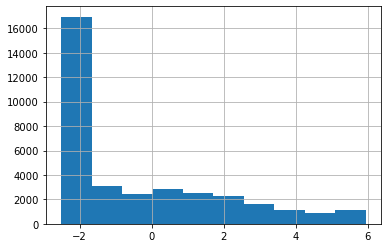

In [45]:
train_df['diff'].hist()

### Train: CNN-LSTM

### Part 1:

In [59]:
# params
n_shot = 5
batch_size = 64
n_epochs = 5
lr = 0.01

# data set up
train_sampler = CL_dff_loader(data_df=train_df,
                              batch_size=batch_size,
                              wv=token_embeddings,
                              aug_wv=aug_token_embeddings,
                              n_shot=n_shot)

valid_sampler = CL_dff_loader(data_df=valid_df,
                              batch_size=batch_size,
                              wv=token_embeddings,
                              aug_wv=aug_token_embeddings,
                              n_shot=n_shot)

# model set up
cnn_lstm = Base_LSTM_CNN(emb_dim=768, seq_len=100, lstm_units=200, num_filters=30, kernel_sizes=[1, 3, 5], num_classes=2)
prto_model = Protonet(cnn_lstm)

train_proto(the_model=prto_model,
            n_epochs=n_epochs,
            learning_rate=lr,
            train_loader_generator=train_sampler,
            valid_loader_generator=valid_sampler,
            n_eposides_train=32,
            n_eposides_valid=32,
            n_shot=n_shot,
            estimate_theta_subsample_size=50,
            the_device=device)

==========Epoch: 1 / 5==========

Train acc: 0.81884765625, Train loss: 1.1052744695916772

Validation acc: 0.900390625, Validation loss: 0.32687396614346653

Current Theta: 2.7997656250000107

Current Train Dataset Length: 30701


==========Epoch: 2 / 5==========

Train acc: 0.931640625, Train loss: 0.18652014143299311

Validation acc: 0.84033203125, Validation loss: 0.5476232464425266

Current Theta: 3.2928125000000117

Current Train Dataset Length: 31649


==========Epoch: 3 / 5==========

Train acc: 0.9228515625, Train loss: 0.2082398529164493

Validation acc: 0.8076171875, Validation loss: 0.48290606308728456

Current Theta: 2.9301562500000102

Current Train Dataset Length: 30969


==========Epoch: 4 / 5==========

Train acc: 0.94287109375, Train loss: 0.1554584497353062

Validation acc: 0.87939453125, Validation loss: 0.3670262536033988

Current Theta: 3.359765625000013

Current Train Dataset Length: 31760


==========Epoch: 5 / 5==========

Train acc: 0.95458984375, Train loss: 

{'train_acc': [0.625,
  0.875,
  0.828125,
  0.859375,
  0.734375,
  0.5625,
  0.734375,
  0.78125,
  0.71875,
  0.828125,
  0.703125,
  0.6875,
  0.515625,
  0.890625,
  0.8125,
  0.78125,
  0.8125,
  0.921875,
  0.875,
  0.75,
  0.859375,
  0.9375,
  0.921875,
  0.90625,
  0.875,
  0.921875,
  0.890625,
  0.921875,
  0.953125,
  0.90625,
  0.875,
  0.9375,
  0.890625,
  0.9375,
  0.875,
  0.890625,
  0.84375,
  0.9375,
  0.9375,
  0.953125,
  0.875,
  0.90625,
  0.953125,
  0.953125,
  0.84375,
  0.96875,
  0.921875,
  0.921875,
  0.953125,
  0.90625,
  0.96875,
  0.96875,
  0.9375,
  0.953125,
  0.953125,
  0.921875,
  0.921875,
  0.9375,
  0.96875,
  0.9375,
  0.96875,
  0.96875,
  0.984375,
  0.953125,
  0.96875,
  0.9375,
  0.953125,
  0.984375,
  0.953125,
  0.890625,
  0.953125,
  0.90625,
  0.9375,
  0.90625,
  0.96875,
  0.984375,
  0.90625,
  0.90625,
  0.875,
  0.953125,
  0.90625,
  0.796875,
  0.9375,
  0.875,
  0.890625,
  0.90625,
  0.921875,
  0.890625,
  0.96875,
  0.

In [60]:
# params
n_shot = 5
batch_size = 64
n_epochs = 5
lr = 0.01

# data set up
train_sampler = CL_dff_loader(data_df=train_df,
                              batch_size=batch_size,
                              wv=token_embeddings,
                              aug_wv=aug_token_embeddings,
                              n_shot=n_shot)

valid_sampler = CL_dff_loader(data_df=valid_df,
                              batch_size=batch_size,
                              wv=token_embeddings,
                              aug_wv=aug_token_embeddings,
                              n_shot=n_shot)

# model set up
cnn_lstm = Base_LSTM_CNN(emb_dim=768, seq_len=100, lstm_units=200, num_filters=30, kernel_sizes=[1, 3, 5], num_classes=2)
prto_model = Protonet(cnn_lstm)

train_proto(the_model=prto_model,
            n_epochs=n_epochs,
            learning_rate=lr,
            train_loader_generator=train_sampler,
            valid_loader_generator=valid_sampler,
            n_eposides_train=32,
            n_eposides_valid=32,
            n_shot=n_shot,
            estimate_theta_subsample_size=1000,
            the_device=device)

==========Epoch: 1 / 5==========

Train acc: 0.76220703125, Train loss: 1.380190558731556

Validation acc: 0.95947265625, Validation loss: 0.1796806906349957

Current Theta: 6.345390625000022

Current Train Dataset Length: 34995


==========Epoch: 2 / 5==========

Train acc: 0.814453125, Train loss: 0.3960344837978482

Validation acc: 0.91943359375, Validation loss: 0.23799325851723552

Current Theta: 6.548750000000023

Current Train Dataset Length: 34995


==========Epoch: 3 / 5==========

Train acc: 0.8447265625, Train loss: 0.3402380612678826

Validation acc: 0.95166015625, Validation loss: 0.19821013626642525

Current Theta: 7.146953125000024

Current Train Dataset Length: 34995


==========Epoch: 4 / 5==========

Train acc: 0.8447265625, Train loss: 0.3876847978681326

Validation acc: 0.97021484375, Validation loss: 0.09395551937632263

Current Theta: 7.040625000000025

Current Train Dataset Length: 34995


==========Epoch: 5 / 5==========

Train acc: 0.8759765625, Train loss: 0.3

{'train_acc': [0.640625,
  0.78125,
  0.734375,
  0.6875,
  0.734375,
  0.625,
  0.578125,
  0.609375,
  0.671875,
  0.6875,
  0.6875,
  0.640625,
  0.78125,
  0.828125,
  0.71875,
  0.75,
  0.75,
  0.765625,
  0.875,
  0.84375,
  0.78125,
  0.765625,
  0.859375,
  0.796875,
  0.90625,
  0.78125,
  0.84375,
  0.859375,
  0.78125,
  0.859375,
  0.90625,
  0.859375,
  0.890625,
  0.828125,
  0.890625,
  0.71875,
  0.8125,
  0.84375,
  0.75,
  0.8125,
  0.78125,
  0.84375,
  0.859375,
  0.828125,
  0.78125,
  0.859375,
  0.828125,
  0.8125,
  0.828125,
  0.84375,
  0.84375,
  0.71875,
  0.859375,
  0.84375,
  0.890625,
  0.84375,
  0.84375,
  0.8125,
  0.859375,
  0.75,
  0.6875,
  0.8125,
  0.78125,
  0.703125,
  0.84375,
  0.84375,
  0.875,
  0.828125,
  0.859375,
  0.765625,
  0.75,
  0.765625,
  0.828125,
  0.875,
  0.875,
  0.90625,
  0.796875,
  0.765625,
  0.859375,
  0.828125,
  0.890625,
  0.828125,
  0.703125,
  0.734375,
  0.78125,
  0.859375,
  0.921875,
  0.828125,
  0.921875

In [67]:
# params
n_shot = 5
batch_size = 64
n_epochs = 5
lr = 0.01

# data set up
train_sampler = CL_dff_loader(data_df=train_df,
                              batch_size=batch_size,
                              wv=token_embeddings,
                              aug_wv=aug_token_embeddings,
                              n_shot=n_shot)

valid_sampler = CL_dff_loader(data_df=valid_df,
                              batch_size=batch_size,
                              wv=token_embeddings,
                              aug_wv=aug_token_embeddings,
                              n_shot=n_shot)

# model set up
cnn_lstm = Base_LSTM_CNN(emb_dim=768, seq_len=100, lstm_units=200, num_filters=30, kernel_sizes=[1, 3, 5], num_classes=2)
prto_model = Protonet(cnn_lstm)

train_proto(the_model=prto_model,
            n_epochs=n_epochs,
            learning_rate=lr,
            train_loader_generator=train_sampler,
            valid_loader_generator=valid_sampler,
            n_eposides_train=32,
            n_eposides_valid=32,
            n_shot=n_shot,
            estimate_theta_subsample_size=500,
            the_device=device)

==========Epoch: 1 / 5==========

Train acc: 0.8115234375, Train loss: 1.3022778192535043

Validation acc: 0.92919921875, Validation loss: 0.21208304772153497

Current Theta: 5.093281250000018

Current Train Dataset Length: 33867


==========Epoch: 2 / 5==========

Train acc: 0.87060546875, Train loss: 0.31803215853869915

Validation acc: 0.97802734375, Validation loss: 0.079365207842784

Current Theta: 6.077578125000022

Current Train Dataset Length: 34995


==========Epoch: 3 / 5==========

Train acc: 0.896484375, Train loss: 0.2588753621093929

Validation acc: 0.89306640625, Validation loss: 0.4110972487833351

Current Theta: 6.032187500000022

Current Train Dataset Length: 34995


==========Epoch: 4 / 5==========

Train acc: 0.89111328125, Train loss: 0.30449875397607684

Validation acc: 0.9658203125, Validation loss: 0.12363101518712938

Current Theta: 6.732890625000023

Current Train Dataset Length: 34995


==========Epoch: 5 / 5==========

Train acc: 0.91259765625, Train loss: 0

{'train_acc': [0.578125,
  0.84375,
  0.71875,
  0.703125,
  0.953125,
  0.78125,
  0.765625,
  0.765625,
  0.84375,
  0.734375,
  0.609375,
  0.703125,
  0.765625,
  0.84375,
  0.734375,
  0.796875,
  0.859375,
  0.90625,
  0.828125,
  0.84375,
  0.921875,
  0.84375,
  0.8125,
  0.828125,
  0.890625,
  0.921875,
  0.875,
  0.78125,
  0.890625,
  0.875,
  0.875,
  0.875,
  0.859375,
  0.796875,
  0.9375,
  0.9375,
  0.90625,
  0.84375,
  0.875,
  0.953125,
  0.84375,
  0.921875,
  0.890625,
  0.890625,
  0.9375,
  0.890625,
  0.84375,
  0.875,
  0.859375,
  0.734375,
  0.8125,
  0.96875,
  0.90625,
  0.953125,
  0.859375,
  0.890625,
  0.84375,
  0.875,
  0.84375,
  0.8125,
  0.703125,
  0.84375,
  0.84375,
  0.90625,
  0.9375,
  0.84375,
  0.84375,
  0.953125,
  0.890625,
  0.90625,
  0.875,
  0.828125,
  0.90625,
  0.859375,
  0.90625,
  0.96875,
  0.921875,
  0.875,
  0.84375,
  0.859375,
  0.890625,
  0.90625,
  0.890625,
  0.90625,
  0.9375,
  0.921875,
  0.859375,
  0.90625,
  0.

### Scoring Function Question

In [61]:
sample_size = 10

for _ in range(10):
    valid_diffs = np.random.exponential(2.0, sample_size) - 1.5
    valid_label = np.ones(sample_size)
    valid_pred = np.array([1] * 8 + [0] * 2)
    np.random.shuffle(valid_pred)
    cur_resp = np.where(valid_pred == valid_label, 1, 0)
    temp_theta = scoring.calculate_theta(difficulties=valid_diffs, response_pattern=cur_resp)[0]
    print(f"Accuracy: {cur_resp.mean()}, Theta: {temp_theta}")

Accuracy: 0.8, Theta: 1.8158593750000067
Accuracy: 0.8, Theta: 1.841406250000007
Accuracy: 0.8, Theta: 2.019531250000008
Accuracy: 0.8, Theta: 1.832812500000007
Accuracy: 0.8, Theta: 1.9978125000000078
Accuracy: 0.8, Theta: 2.2521093750000087
Accuracy: 0.8, Theta: 1.4890625000000055
Accuracy: 0.8, Theta: 2.3806250000000087
Accuracy: 0.8, Theta: 1.7240625000000065
Accuracy: 0.8, Theta: 1.7513281250000068


In [62]:
sample_size = 100

for _ in range(10):
    valid_diffs = np.random.exponential(2.0, sample_size) - 1.5
    valid_label = np.ones(sample_size)
    valid_pred = np.array([1] * 80 + [0] * 20)
    np.random.shuffle(valid_pred)
    cur_resp = np.where(valid_pred == valid_label, 1, 0)
    temp_theta = scoring.calculate_theta(difficulties=valid_diffs, response_pattern=cur_resp)[0]
    print(f"Accuracy: {cur_resp.mean()}, Theta: {temp_theta}")

Accuracy: 0.8, Theta: 4.390312500000016
Accuracy: 0.8, Theta: 4.125312500000014
Accuracy: 0.8, Theta: 5.033359375000018
Accuracy: 0.8, Theta: 4.221328125000015
Accuracy: 0.8, Theta: 4.376484375000015
Accuracy: 0.8, Theta: 5.094296875000017
Accuracy: 0.8, Theta: 4.949687500000017
Accuracy: 0.8, Theta: 5.4034375000000185
Accuracy: 0.8, Theta: 5.36851562500002
Accuracy: 0.8, Theta: 4.972265625000018


In [66]:
sample_size = 1000

for _ in range(10):
    valid_diffs = np.random.exponential(2.0, sample_size) - 1.5
    valid_label = np.ones(sample_size)
    valid_pred = np.array([1] * 800 + [0] * 200)
    np.random.shuffle(valid_pred)
    cur_resp = np.where(valid_pred == valid_label, 1, 0)
    temp_theta = scoring.calculate_theta(difficulties=valid_diffs, response_pattern=cur_resp)[0]
    print(f"Accuracy: {cur_resp.mean()}, Theta: {temp_theta}")

Accuracy: 0.8, Theta: 8.317031250000028
Accuracy: 0.8, Theta: 8.398906250000028
Accuracy: 0.8, Theta: 8.76359375000003
Accuracy: 0.8, Theta: 8.44718750000003
Accuracy: 0.8, Theta: 8.628984375000032
Accuracy: 0.8, Theta: 8.674765625000033
Accuracy: 0.8, Theta: 8.899375000000031
Accuracy: 0.8, Theta: 8.45976562500003
Accuracy: 0.8, Theta: 8.667890625000032
Accuracy: 0.8, Theta: 8.324140625000028


In [65]:
sample_size = 10000

for _ in range(10):
    valid_diffs = np.random.exponential(2.0, sample_size) - 1.5
    valid_label = np.ones(sample_size)
    valid_pred = np.array([1] * 8000 + [0] * 2000)
    np.random.shuffle(valid_pred)
    cur_resp = np.where(valid_pred == valid_label, 1, 0)
    temp_theta = scoring.calculate_theta(difficulties=valid_diffs, response_pattern=cur_resp)[0]
    print(f"Accuracy: {cur_resp.mean()}, Theta: {temp_theta}")

Accuracy: 0.8, Theta: 12.240078125000043
Accuracy: 0.8, Theta: 12.188515625000042
Accuracy: 0.8, Theta: 12.460078125000043
Accuracy: 0.8, Theta: 11.96085937500004
Accuracy: 0.8, Theta: 12.738203125000046
Accuracy: 0.8, Theta: 12.968359375000047
Accuracy: 0.8, Theta: 12.535468750000046
Accuracy: 0.8, Theta: 12.936250000000044
Accuracy: 0.8, Theta: 12.278593750000045
Accuracy: 0.8, Theta: 12.155625000000043
